## Классификация сервисов яндекс при помощи модели Random Forest

### Загрузим библиотеки

In [1]:
import pandas as pd

print("Pandas version: ", pd.__version__)

import sys  

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
# from sklearn.cross_validation import  cross_val_score



Pandas version:  1.4.4


In [2]:
current_path = ''

# current_path = 'iter-20230609/by_balabanov'
df_final_filename = f'data/df_final_4serv.csv'

dfFinal = pd.read_csv(df_final_filename)

print('df_final: ', dfFinal.shape)

df_final:  (8375, 40)


#### Посмотрим датасету в глаза

In [3]:
dfFinal

,proto,packets_count,f_pkts_num,min_fiat,min_biat,flow_packets_per_second,f_min_pkt_size,f_max_pkt_size,b_min_pkt_size,b_max_pkt_size,...,type,total_fiat,pktlen_5,pktlen_6,pktlen_7,pktlen_9,tcp_psh_count,pktiat_5,pktlen_0,pktlen_4
0,6,10,4.0,0.000018,0.000013,0.000000,66,583.0,66,1414.0,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6,10,4.0,0.000691,0.000010,1.000000,66,583.0,66,1414.0,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6,10,4.0,0.001067,0.000013,1.000000,66,583.0,66,1414.0,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,6,10,4.0,0.001791,0.000009,0.000000,66,583.0,66,1414.0,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6,10,4.0,0.000975,0.000011,0.000000,66,583.0,66,1414.0,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8370,6,8,NaN,0.000023,0.000057,35.191284,20,356.0,20,595.0,...,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,356.0,NaN
8371,6,6,NaN,0.068099,0.000418,42.825969,20,88.0,20,323.0,...,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,88.0,NaN
8372,6,8,NaN,0.062934,0.003954,38.765527,20,576.0,20,319.0,...,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,484.0,NaN
8373,6,10,NaN,0.102423,0.026742,21.902108,20,426.0,20,305.0,...,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,93.0,NaN


#### Удалим nan

In [4]:
dfFinal.dropna(axis=1,inplace=True)
dfFinal.shape

(8375, 20)

#### Выделим target и удалим колонки (по необходимости)

In [5]:
dfFinal

,proto,packets_count,min_fiat,min_biat,flow_packets_per_second,f_min_pkt_size,b_min_pkt_size,diag_step_fiat,diag_step_biat,diag_steps,tcp_syn_count,tcp_rst_count,tcp_fin_count,tcp_urg_count,tcp_retr_count,pktiat_0,pktiat_1,pktiat_2,pktlen_1,type
0,6,10,0.000018,0.000013,0.000000,66,66,12.639972,12.638208,12.639972,0,0,0,0,10,0.0,0.003897,0.005288,66,1
1,6,10,0.000691,0.000010,1.000000,66,66,12.639972,12.638208,12.639972,0,0,0,0,10,0.0,0.007042,0.000323,66,1
2,6,10,0.001067,0.000013,1.000000,66,66,12.639972,12.638208,12.639972,0,0,0,0,10,0.0,0.006890,0.000321,66,1
3,6,10,0.001791,0.000009,0.000000,66,66,12.639972,12.638208,12.639972,0,0,0,0,10,0.0,0.004396,0.000803,66,1
4,6,10,0.000975,0.000011,0.000000,66,66,12.639972,12.638208,12.639972,0,0,0,0,10,0.0,0.007156,0.000235,66,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8370,6,8,0.000023,0.000057,35.191284,20,20,4.801381,4.800036,4.801381,0,0,2,0,2,0.0,0.016593,0.178926,20,3
8371,6,6,0.068099,0.000418,42.825969,20,20,4.801381,4.800036,4.801381,0,0,2,0,1,0.0,0.003998,0.068005,323,3
8372,6,8,0.062934,0.003954,38.765527,20,20,4.801381,4.800036,4.801381,0,1,1,0,0,0.0,0.039044,0.038088,292,3
8373,6,10,0.102423,0.026742,21.902108,20,20,4.801381,4.800036,4.801381,0,0,1,0,1,0.0,0.097085,0.026742,20,3


In [6]:
y = dfFinal['type']
drop_col = ['type','proto','diag_step_fiat','diag_step_biat','diag_steps', 'pktiat_1',  'pktiat_2']
X  = dfFinal.drop(columns=drop_col)
X.columns

Index(['packets_count', 'min_fiat', 'min_biat', 'flow_packets_per_second',
       'f_min_pkt_size', 'b_min_pkt_size', 'tcp_syn_count', 'tcp_rst_count',
       'tcp_fin_count', 'tcp_urg_count', 'tcp_retr_count', 'pktiat_0',
       'pktlen_1'],
      dtype='object')

#### Разобьем данные на подопытные и проверочные

In [7]:
X_train, X_test, y_train, y_test = X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.3,
                                                        random_state=42,
                                                        stratify=None)

#### Погуляем по случайному лесу

In [8]:
estimator = RandomForestClassifier()

##### ...со следующим набором параметров

In [9]:
parameters = {
    'n_estimators': [50, 200, 700],
    'max_features': ['sqrt', 'log2']
}

In [10]:
grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'accuracy',
    n_jobs = 5,
    cv = 10,
    verbose=True
)

In [11]:
grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


GridSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=5,
             param_grid={'max_features': ['sqrt', 'log2'],
                         'n_estimators': [50, 200, 700]},
             scoring='accuracy', verbose=True)

In [12]:
grid_search.best_estimator_

RandomForestClassifier(max_features='log2', n_estimators=700)

In [13]:
predictions_RFC = grid_search.predict(X_test)

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (confusion_matrix, accuracy_score, ConfusionMatrixDisplay)

In [15]:
def plot_confusion_matrix(y_test, prediction, model_name, index=["0", "1", "2"], columns=["0", "1", "2"]):
    cm = confusion_matrix(y_test, prediction)
    cm_df = pd.DataFrame(cm, index, columns)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm_df, annot=True, fmt='g', annot_kws={"size": 10})
    plt.title(model_name+'\nAccuracy:{0:.4f}'.format(accuracy_score(y_test, prediction)))
    plt.ylabel('True Label', fontsize=1)
    plt.show()


def display_confusion_matrix(y_test, prediction, display_labels=["0", "1", "2"]):
    cm = confusion_matrix(y_test, prediction)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    cm_display.plot()
    plt.show()


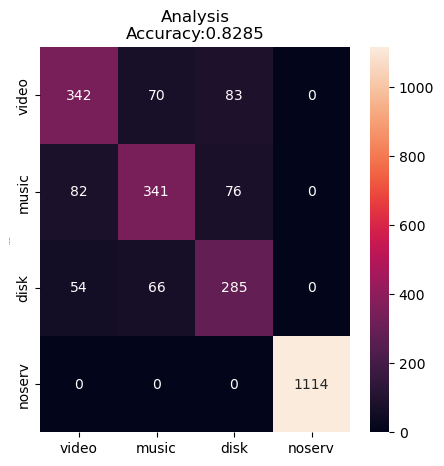

In [16]:
plot_confusion_matrix(y_test, predictions_RFC.round(), "Analysis", index=["video", "music", "disk", "noserv"], columns=["video", "music", "disk", "noserv"])

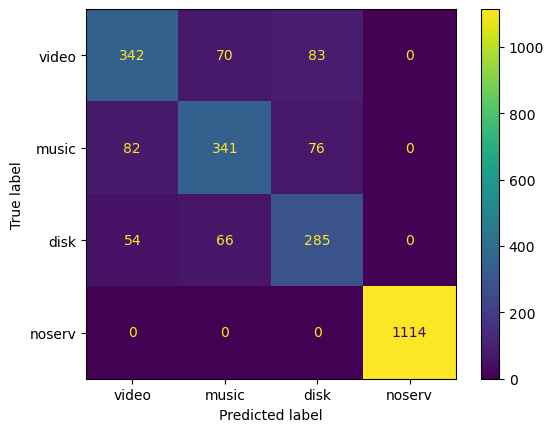

In [17]:
display_confusion_matrix(y_test, predictions_RFC.round(), display_labels=["video", "music", "disk","noserv"])

In [18]:
feature_importances = grid_search.best_estimator_.feature_importances_ / 2
feature_importances = pd.DataFrame({'feature': list(X.columns),
                                    'importance': feature_importances}
                                  ).sort_values('importance', ascending = False)

feature_importances

,feature,importance
1,min_fiat,0.154230
2,min_biat,0.095099
3,flow_packets_per_second,0.077024
10,tcp_retr_count,0.067973
5,b_min_pkt_size,0.044610
4,f_min_pkt_size,0.038115
8,tcp_fin_count,0.012435
12,pktlen_1,0.009088
0,packets_count,0.001315
7,tcp_rst_count,0.000111
